# Question 3 : An Efficient CNNModel for COVID-19 Disease Detection Based on X-Ray Image Classification


## Task :

<ul>
<li>Covid detection using CNN networks with low rate of falsy cases.</li>


</ul>


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import os
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shutil
from google.colab import drive
from google.colab import files


## Data collection and download

 get the kaggle data-set

In [ ]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
 99% 2.28G/2.29G [00:20<00:00, 166MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s]


 get the github data-set

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git


Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 35.53 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


create data for positive samples (Github)

In [ ]:
FILE_PATH = "/content/covid-chestxray-dataset/metadata.csv"
IMAGE_PATH = "/content/covid-chestxray-dataset/images/"


In [ ]:
df = pd.read_csv(FILE_PATH)
print(df.shape)

(950, 30)


In [ ]:
df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
DIR_NORMAL = os.path.join(PARENT_DIR, "Normal")
TARGET_DIR_COVID = os.path.join(PARENT_DIR, "Covid")
PARENT_DIR = "/content/Dataset"

In [ ]:


if not os.path.exists(PARENT_DIR):
    os.mkdir(PARENT_DIR)
    print("Parent directory created")

if not os.path.exists(TARGET_DIR_COVID):
    os.mkdir(TARGET_DIR_COVID)
    print("Covid folder created")
if not os.path.exists(DIR_NORMAL):
    os.mkdir(DIR_NORMAL)
    print("Normal directory created")


Parent directory created
Covid folder created
Normal directory created


### Of 178 images, 136 X-ray images belonged to confirmed COVID-19 patients and other 42 images belonged to normal or people with other diseases

### Analysis of X-Ray Images by Medical Experts. A deep analysis was done on the X-ray images by medical specialists. Out of 135 X-ray images of confirmed COVID-19 patients,only a set of 90 X-ray images was selected as a perfect candidate to train the models.

In [ ]:
# if os.path.exists(TARGET_DIR_COVID):
#     shutil.rmtree(TARGET_DIR_COVID)
#     print(f"{TARGET_DIR_COVID} folder cleared")

# if os.path.exists(DIR_NORMAL):
#     shutil.rmtree(DIR_NORMAL)
#     print(f"{DIR_NORMAL} folder cleared")

/content/Dataset/Covid folder cleared
/content/Dataset/Normal folder cleared


In [ ]:
cnt_covid = 0

max_images_covid = 90

for i, row in df.iterrows():
    filename = row["filename"]
    image_path = os.path.join(IMAGE_PATH, filename)

    if row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA" and cnt_covid < max_images_covid:
        image_copy_path = os.path.join(TARGET_DIR_COVID, f"covid_{cnt_covid}.png")
        shutil.copy2(image_path, image_copy_path)
        cnt_covid += 1

        if cnt_covid >= max_images_covid:
            break


print(f"{cnt_covid} COVID-19 images (renamed) copied to {TARGET_DIR_COVID}")

90 COVID-19 images (renamed) copied to /content/Dataset/Covid


In [ ]:
cnt_normal = 0
max_images_normal = 42
for i, row in df.iterrows():
    filename = row["filename"]
    image_path = os.path.join(IMAGE_PATH, filename)

    if row["finding"] != "Pneumonia/Viral/COVID-19" and cnt_normal < max_images_normal:
        image_copy_path = os.path.join(DIR_NORMAL, f"normal_{cnt_normal}.png")
        shutil.copy2(image_path, image_copy_path)
        cnt_normal += 1

    if  cnt_normal >= max_images_normal:
        break

print(f"{cnt_normal} normal images copied to {DIR_NORMAL}")

42 normal images copied to /content/Dataset/Normal


### Balancing Dataset Classes: COVID-19 cases, 136 normal chest X-ray images have been used. Extra X-ray images were downloaded from Kaggle

In [ ]:
ADDITIONAL_NORMAL_DIR = "/content/chest_xray/train/NORMAL"

cnt_additional_normal = 0

max_additional_normal_images = 136

for filename in os.listdir(ADDITIONAL_NORMAL_DIR):
    if cnt_additional_normal >= max_additional_normal_images:
        break

    image_path = os.path.join(ADDITIONAL_NORMAL_DIR, filename)
    image_copy_path = os.path.join(DIR_NORMAL, f"normal_{cnt_additional_normal + max_images_normal}.png")

    shutil.copy2(image_path, image_copy_path)
    cnt_additional_normal += 1

print(f"{cnt_additional_normal} additional normal images copied to {DIR_NORMAL}")


136 additional normal images copied to /content/Dataset/Normal


## Working on new dataset (emailed one, fine gathered from paper sources)

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

dataset_path = '/content/drive/MyDrive/NN_Q3_Dataset/Dataset.zip'

extraction_path = '/content/dataset/'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [4]:
dataset_base_directory = '/content/dataset/Dataset/xray_dataset_covid19/'
sub_directories = ['train/', 'test/']

classes = os.listdir(os.path.join(dataset_base_directory, sub_directories[0]))

num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print("Classes:")
for class_name in classes:
    print(class_name)


Number of classes: 2
Classes:
NORMAL
COVID


normalization images

In [5]:
IMG_SIZE = 150

In [6]:
X = []
y = []

for sub_dir in sub_directories:
    for c in range(len(classes)):
        dir = os.path.join(dataset_base_directory, sub_dir, classes[c])

        for f in os.listdir(dir):
            img = cv2.imread(os.path.join(dir, f))
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            X.append(img)
            y.append(c)

X = np.asarray(X)
y = np.asarray(y)



In [7]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("Label distribution:", np.bincount(y) / len(y))

Shape of X: (188, 150, 150, 3)
Shape of y: (188,)
Label distribution: [0.5 0.5]


## Data Augmentation

Based on table 2 of paper: `An Efficient CNNModel for COVID-19 Disease Detection Based on X-Ray Image Classification`

---
Original 90

Original flipped 90

Original with a 90-degree rotation 90

Original with 180-degree rotation 90

Original with 270-degree rotation 90

Total 450

In [8]:
X_reversed = np.flip(X, axis=2)
y_reversed = y

X = np.concatenate((X, X_reversed), axis=0)
y = np.concatenate((y, y_reversed), axis=0)

X_rotated_90= np.rot90(X, axes=(1, 2))
# X_rotated_180 = np.rot90(X_rotated_90, axes=(1, 2))
# X_rotated_270 = np.rot90(X_rotated_180, axes=(1, 2))

y_rotated = y

X = np.concatenate((X, X_rotated_90), axis=0)
# X = np.concatenate((X, X_rotated_180), axis=0)
# X = np.concatenate((X, X_rotated_270), axis=0)
y = np.concatenate((y, y_rotated), axis=0)
# y = np.concatenate((y, y_rotated), axis=0)
# y = np.concatenate((y, y_rotated), axis=0)



In [9]:
print("Shape of X_combined:", X.shape)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", len(X))
print("Number of labels:", len(y))
print("Unique labels:", np.unique(y))
print("Label distribution:", np.bincount(y) / len(y))


Shape of X_combined: (752, 150, 150, 3)
Shape of X: (752, 150, 150, 3)
Shape of y: (752,)
Number of samples: 752
Number of labels: 752
Unique labels: [0 1]
Label distribution: [0.5 0.5]


split the data train, test, and validation

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, test_index = next(splitter.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(splitter.split(X_test, y_test))

X_test, X_val = X_test[test_index], X_test[val_index]
y_test, y_val = y_test[test_index], y_test[val_index]

In [11]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (601, 150, 150, 3)
Shape of y_train: (601,)
Shape of X_val: (76, 150, 150, 3)
Shape of y_val: (76,)
Shape of X_test: (75, 150, 150, 3)
Shape of y_test: (75,)


printing the class distribution | According to Table 1 paper

In [12]:
print(f'\t\t{classes[0]}\t\t{classes[1]}')
print(f'training:\t{np.count_nonzero(y_train==0)}\t\t{np.count_nonzero(y_train==1)}')
print(f'validation:\t{np.count_nonzero(y_val==0)}\t\t{np.count_nonzero(y_val==1)}')
print(f'testing:\t{np.count_nonzero(y_test==0)}\t\t{np.count_nonzero(y_test==1)}')


		NORMAL		COVID
training:	300		301
validation:	38		38
testing:	38		37


show random instance images

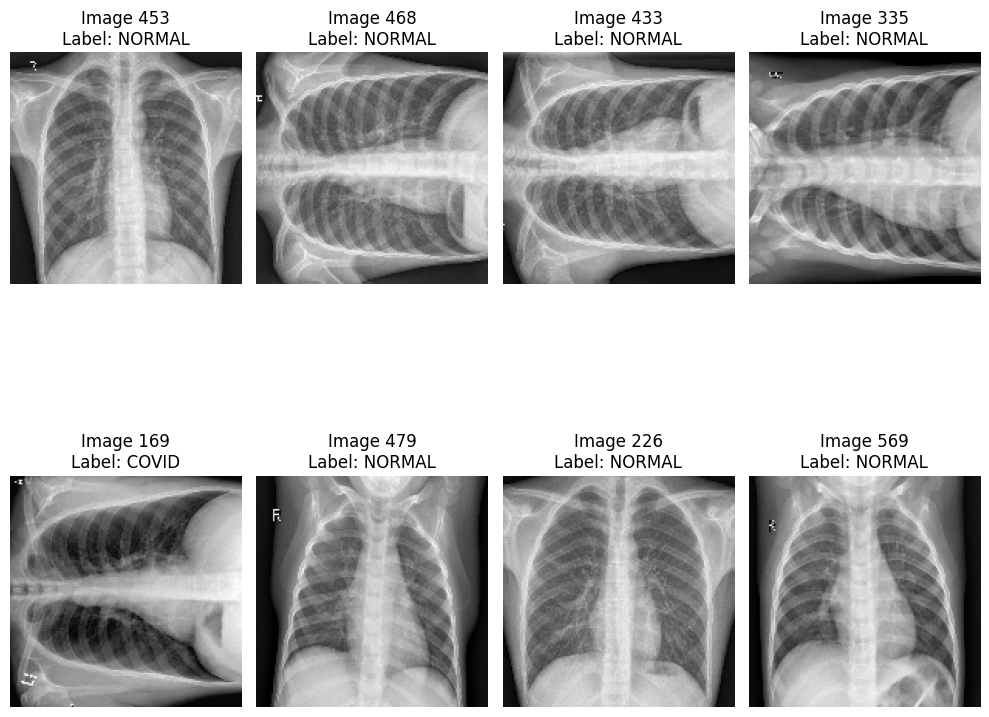

In [13]:
import random

num_images = 8

random_indices = random.sample(range(len(X_train)), num_images)

fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

for i, index in enumerate(random_indices):
    image = X_train[index]
    label = y_train[index]

    image_number = index + 1
    axes[i].set_title(f"Image {image_number}\nLabel: {classes[label]}")

    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### Model Architecture

In [13]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])

In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0

#### train model

In [14]:
from keras.preprocessing import image

train_datagen = image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0.0
)
test_dataset = image.ImageDataGenerator(rescale = 1./255)

In [15]:
data_iterator = train_datagen.flow(X_train, y_train, batch_size=32)
steps_per_epoch = X_train.shape[0] // 32
data_iterator.x.size


40567500

train_generator.class_indices


In [18]:
validation_generator = test_dataset.flow_from_directory(
    '/content/chest_xray/val/',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 16 images belonging to 2 classes.


#### Fit The Model

In [16]:
# input_layer = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# efficientNet = keras.applications.EfficientNetB3(
#     include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

# x = efficientNet(input_layer, training=True)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(IMG_SIZE, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
# x = keras.layers.Dense(64, activation='relu')(x)
# x = keras.layers.Dropout(0.2)(x)
# output_layer = keras.layers.Dense(1, activation='sigmoid')(x)

# model = keras.Model(input_layer, output_layer)

43941136/43941136 [==============================] - 1s 0us/step


In [17]:
# for layer in efficientNet.layers[:74]:
#     layer.trainable = False


In [30]:

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

In [43]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=30,
    verbose=1,
    restore_best_weights=True

)
checkpoints = ModelCheckpoint(
    'temp_final/checkpoint',
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,
    verbose=1
)





In [44]:
model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])

In [45]:
hist = model.fit(
    data_iterator,
    epochs = 50,
    class_weight = class_weight,
    steps_per_epoch = steps_per_epoch,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, checkpoints]

)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8963
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to temp_final/checkpoint


18/18 [==============================] - 82s 4s/step - loss: 0.2721 - accuracy: 0.8963 - val_loss: 2.3750 - val_accuracy: 0.5000
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9262
Epoch 2: val_accuracy did not improve from 0.50000
18/18 [==============================] - 72s 4s/step - loss: 0.1826 - accuracy: 0.9262 - val_loss: 6.1123 - val_accuracy: 0.5000
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9631
Epoch 3: val_accuracy did not improve from 0.50000
18/18 [==============================] - 75s 4s/step - loss: 0.1118 - accuracy: 0.9631 - val_loss: 6.2592 - val_accuracy: 0.5000
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9508
Epoch 4: val_accuracy did not improve from 0.50000
18/18 [==============================] - 70s 4s/step - loss: 0.1320 - accuracy: 0.9508 - val_loss: 5.7431 - val_accuracy: 0.5000
Epoch 5/50
18/18 [==============================]

18/18 [==============================] - 78s 4s/step - loss: 0.1120 - accuracy: 0.9666 - val_loss: 2.6591 - val_accuracy: 0.5132
Epoch 19/50
18/18 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9736
Epoch 19: val_accuracy did not improve from 0.51316
18/18 [==============================] - 69s 4s/step - loss: 0.0755 - accuracy: 0.9736 - val_loss: 2.0022 - val_accuracy: 0.5132
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9754
Epoch 20: val_accuracy did not improve from 0.51316
18/18 [==============================] - 71s 4s/step - loss: 0.0646 - accuracy: 0.9754 - val_loss: 4.4073 - val_accuracy: 0.5000
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9740
Epoch 21: val_accuracy did not improve from 0.51316
18/18 [==============================] - 72s 4s/step - loss: 0.0801 - accuracy: 0.9740 - val_loss: 4.1501 - val_accuracy: 0.5132
Epoch 22/50
18/18 [========================

18/18 [==============================] - 73s 4s/step - loss: 0.0197 - accuracy: 0.9965 - val_loss: 1.6085 - val_accuracy: 0.6053
Epoch 29/50
18/18 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9912
Epoch 29: val_accuracy improved from 0.60526 to 0.84211, saving model to temp_final/checkpoint


18/18 [==============================] - 75s 4s/step - loss: 0.0371 - accuracy: 0.9912 - val_loss: 0.7960 - val_accuracy: 0.8421
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9859
Epoch 30: val_accuracy improved from 0.84211 to 0.85526, saving model to temp_final/checkpoint


18/18 [==============================] - 75s 4s/step - loss: 0.0340 - accuracy: 0.9859 - val_loss: 0.6903 - val_accuracy: 0.8553
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9754
Epoch 31: val_accuracy did not improve from 0.85526
18/18 [==============================] - 70s 4s/step - loss: 0.0529 - accuracy: 0.9754 - val_loss: 1.0528 - val_accuracy: 0.7763
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9807
Epoch 32: val_accuracy did not improve from 0.85526
18/18 [==============================] - 70s 4s/step - loss: 0.0707 - accuracy: 0.9807 - val_loss: 0.7828 - val_accuracy: 0.8289
Epoch 33/50
18/18 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9719
Epoch 33: val_accuracy did not improve from 0.85526
18/18 [==============================] - 69s 4s/step - loss: 0.0746 - accuracy: 0.9719 - val_loss: 0.6295 - val_accuracy: 0.7632
Epoch 34/50
18/18 [========================

18/18 [==============================] - 77s 4s/step - loss: 0.0508 - accuracy: 0.9772 - val_loss: 0.1766 - val_accuracy: 0.9474
Epoch 36/50
18/18 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9912
Epoch 36: val_accuracy did not improve from 0.94737
18/18 [==============================] - 70s 4s/step - loss: 0.0230 - accuracy: 0.9912 - val_loss: 3.1055 - val_accuracy: 0.5263
Epoch 37/50
18/18 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9789
Epoch 37: val_accuracy did not improve from 0.94737
18/18 [==============================] - 72s 4s/step - loss: 0.0488 - accuracy: 0.9789 - val_loss: 0.8372 - val_accuracy: 0.7763
Epoch 38/50
18/18 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9912
Epoch 38: val_accuracy did not improve from 0.94737
18/18 [==============================] - 70s 4s/step - loss: 0.0371 - accuracy: 0.9912 - val_loss: 0.2165 - val_accuracy: 0.9474
Epoch 39/50
18/18 [========================

18/18 [==============================] - 75s 4s/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 0.0680 - val_accuracy: 0.9737
Epoch 45/50
18/18 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9930
Epoch 45: val_accuracy did not improve from 0.97368
18/18 [==============================] - 72s 4s/step - loss: 0.0265 - accuracy: 0.9930 - val_loss: 2.3441 - val_accuracy: 0.5263
Epoch 46/50
18/18 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9947
Epoch 46: val_accuracy did not improve from 0.97368
18/18 [==============================] - 69s 4s/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 2.1944 - val_accuracy: 0.5000
Epoch 47/50
18/18 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9912
Epoch 47: val_accuracy did not improve from 0.97368
18/18 [==============================] - 72s 4s/step - loss: 0.0208 - accuracy: 0.9912 - val_loss: 3.0615 - val_accuracy: 0.4868
Epoch 48/50
18/18 [========================

load model check point

In [54]:
from tensorflow.keras.models import load_model

loaded_model = load_model('temp_final/checkpoint')

Plot the loss and accuracy

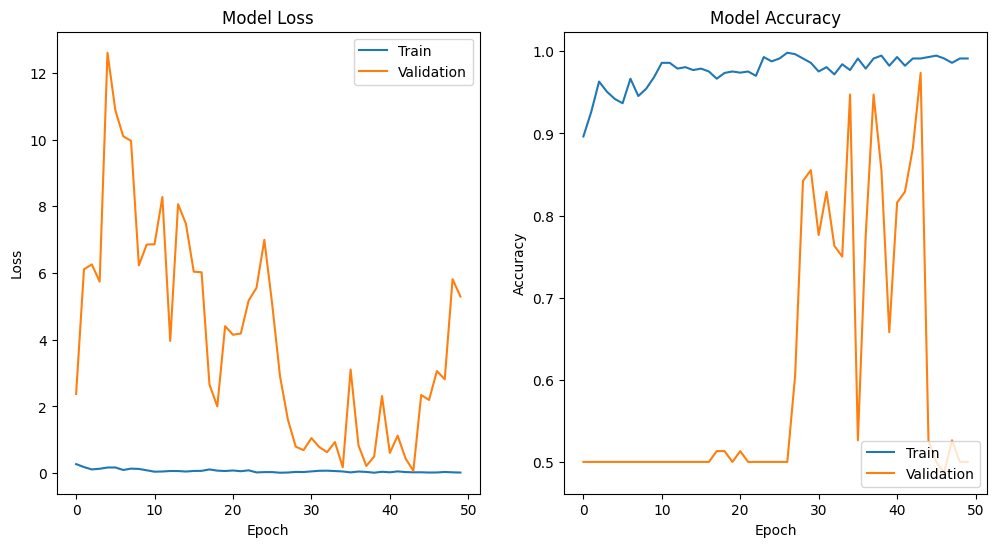

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Evaluation
#### Evaluate the trained network on the test data and report the Accuracy,Precision, Specificity, Sensitivity and 1F score. Draw the confusion matrix

In [56]:
probas = loaded_model.predict(X_test)

y_pred = np.asarray(0.5 < probas, dtype=np.int32)
y_pred_binary = (y_pred > 0.5).astype(int)


3/3 [==============================] - 4s 1s/step


3/3 [==============================] - 3s 823ms/step - loss: 0.0059 - accuracy: 1.0000

Test Loss: 0.0059
Test Accuracy: 100.00%
3/3 [==============================] - 2s 447ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        37

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



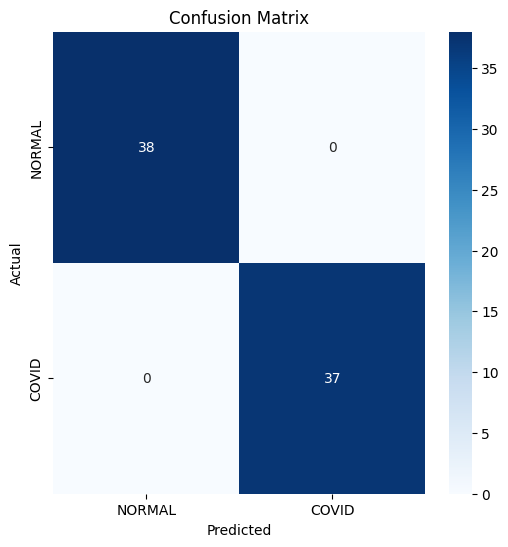

In [57]:

test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = loaded_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

conf_mat = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "COVID"], yticklabels=["NORMAL", "COVID"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


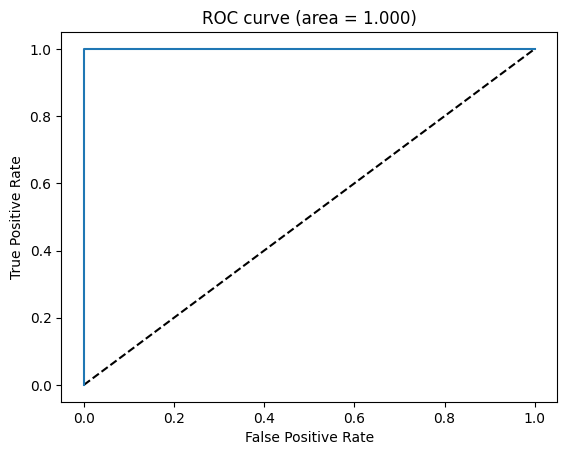

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, probas.ravel())

area_under_curve = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.3f})'.format(area_under_curve))
plt.show()